In [1]:
import numpy as np
import math
import time
from datetime import datetime
import os
import shutil # for copying checkpoint to "last"
from pathlib import Path

import torch
import torch.nn as nn
import torchvision.transforms as transform

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pylab as plt
%matplotlib inline

from audioDataLoader.mulaw import mu_law_encode, mu_law_decode
from audioDataLoader.audio_dataset import AudioDatasetConfig, MuLawAudioDataset2
from torch.utils.data import DataLoader

import model.gru_audio_model
from audioDataLoader.dac_dataset import AudioDatasetConfig, DACDataset



### Data Params  
<a id="dataparams"></a>

These parameters are saved to file, and serve several purposes:
* The allow other programs to properly evaluate and visualize the trained (and also saved) models,
* Provide a record of the parameters that allow reproducing results. 

In [2]:
resume_checkpoint= None # str(Path("./output/20250808_182912/")) 
#sourcedatadir = str(Path('./data/nsynth.64.76_sm'))
sourcedatadir = os.path.join(os.getcwd(), 'data', 'dac_encoded_audio' )

params = dict(
    # Read/write directory of data & parameter files
    #*************************************
    sample_rate=16000,
    runTimeStamp='{:%Y-%m-%d_%H-%M-%S}'.format(datetime.now()),
    
    datadir = sourcedatadir,
    paramdir = sourcedatadir,

    savemodel = True,
    savemodel_interval = 10, # in units of epochs
    savemodeldir = os.path.join(os.getcwd(), 'output'), # default saving directory for models and the parameterization

    # Training parameters ----------------------------------------------
    num_epochs = 40, # of batches_per_epoch of batch_size sequeunce
    batches_per_epoch = 100, 
    batch_size = 256, 
    
    noise=.1,
    seqLen = 256, 
    #stride = 1,
    
    lr = 0.005,
    # parameter names for the Data Loader to search for in the filenames, and the range that maps to [0,1] for training and inference
    # The order specified in this structure will be the order used for inference
    props={"instID": (1, 2), "a": (0,1), "p": (64.0, 76.0)},
    
    # Model parameters
    input_size = 1,
    hiddenSize = 24, #100,
    nLayers = 3,
    numtokens = 1024, # mulaw quant levels
    dropout = 0.1
)

In [3]:
params

{'sample_rate': 16000,
 'runTimeStamp': '2025-08-21_21-03-00',
 'datadir': '/Users/jeddo/Documents/RNNControl2/data/dac_encoded_audio',
 'paramdir': '/Users/jeddo/Documents/RNNControl2/data/dac_encoded_audio',
 'savemodel': True,
 'savemodel_interval': 10,
 'savemodeldir': '/Users/jeddo/Documents/RNNControl2/output',
 'num_epochs': 40,
 'batches_per_epoch': 100,
 'batch_size': 256,
 'noise': 0.1,
 'seqLen': 256,
 'lr': 0.005,
 'props': {'instID': (1, 2), 'a': (0, 1), 'p': (64.0, 76.0)},
 'input_size': 1,
 'hiddenSize': 24,
 'nLayers': 3,
 'numtokens': 1024,
 'dropout': 0.1}

### Run Params 

In [4]:
sr = params['sample_rate']

log_interval = 1 # units of epochs
visualize_interval = log_interval # units of epochs

#Generation parameters
#*************************************
max_length = params['seqLen']*3  #length of the sequence used to inspect progress in audio plots during training

# Cuda
#*************************************
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device='cpu'
device

device(type='cpu')

In [5]:
# Some utility functions
#*************************************
def time_taken(elapsed):
    """To format time taken in hh:mm:ss. Use with time.monotic()"""
    m, s = divmod(elapsed, 60)
    h, m = divmod(m, 60)
    return "%d:%02d:%02d" % (h, m, s)

def mydate() :
    return (datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

def inputcoding(samp) :
    return mu_law_encode(np.array(samp), params['numtokens'])/(params['numtokens']-1.0)

def index2float(topi) :
    return(mu_law_decode(topi[0][0]).cpu().numpy(), params['numtokens'])


In [6]:

#--- model settings ----#
model_config = model.gru_audio_model.GRUAudioConfig (
    input_size = params['input_size'],
    cond_size = len(params['props']),
    hidden_size = params['hiddenSize'],
    num_layers = params['nLayers'],
    numtokens = params['numtokens'],  #mu-law quantization levels
    dropout = params['dropout']
)

# ---- Training Settings ----
data_config = AudioDatasetConfig(
   data_dir=params['datadir'],
   sequence_length=params['seqLen'],
   parameter_specs=params['props'],
   add_noise= False if params['noise'] == 0 else True,   # Whether to add white noise
   noise_weight = params['noise'],                           # Desired signal-to-noise ratio (dB)
   encode=True,
   numtokens=params['numtokens']
)

# ---- Generation Settings ----
testdata_config = AudioDatasetConfig(
   data_dir=params['datadir'],
   sequence_length=params['seqLen'],
   parameter_specs=params['props'],
   add_noise= False,                        # no noise for testing and priming
   noise_weight = params['noise'],                           # Desired signal-to-noise ratio (dB)
   encode=False,
   numtokens=params['numtokens']
)

# === Dataset and Loader ===
dataset = DACDataset(data_config)
train_loader = DataLoader(dataset,
                             batch_size=params['batch_size'],
                             shuffle=True,
                             num_workers=0,
                             drop_last=True)

testdataset = DACDataset(testdata_config)
test_loader = DataLoader(testdataset,
                            batch_size=1,
                            shuffle=True,
                            num_workers=0,
                            drop_last=True)
   
# The data "size" is the number of possible sequences the data loader can provide.
# Since the sequences are chosen randomly from the file, the number of possible sequence is the total number of audio samples in the set (minus the ones that start less than sequence length from the end of the files)
print("size of dataset is",len(dataset))
print("no. of batches per epoch is", params['batches_per_epoch'])
print("batchsize id  is", params['batch_size'])

/opt/anaconda3/envs/basicaudio/lib/python3.13/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


size of dataset is 14016
no. of batches per epoch is 100
batchsize id  is 256


size of dataset is 14016
no. of batches per epoch is 100
batchsize id  is 256
rand_sample: idx=9391
rand_sample: file_idx=4
rand_sample: start_pos=47, end_pos=304
torch.Size([257])


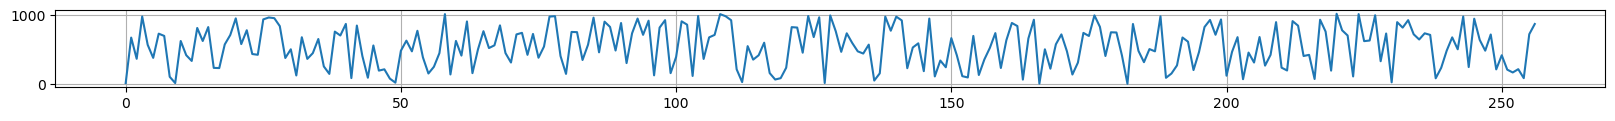

/var/folders/kf/3rx3bfc940b137fg73y33nqm0000gn/T/ipykernel_40885/927132757.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return mu_law_encode(np.array(samp), params['numtokens'])/(params['numtokens']-1.0)


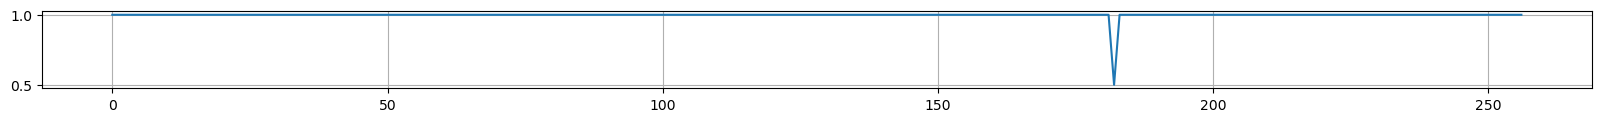

bat num 0 at time 2025-08-21 21:03:02
x_audio_seq.shape = torch.Size([1, 256, 4])
y_target_seq.shape = torch.Size([1, 256, 1])
bat num 1 at time 2025-08-21 21:03:02
x_audio_seq.shape = torch.Size([1, 256, 4])
y_target_seq.shape = torch.Size([1, 256, 1])
finished at 2025-08-21 21:03:02


In [7]:
# just show some stuff 

print("size of dataset is",len(dataset))
print("no. of batches per epoch is", params['batches_per_epoch'])
print("batchsize id  is", params['batch_size'])

samp = dataset.rand_sample()
print(samp.shape)
plt.figure(figsize=(20,1)) 
plt.plot(np.arange(len(samp)), samp) #just print one example from the batch
plt.grid()
plt.show()

samp = inputcoding(samp)
plt.figure(figsize=(20,1)) 
plt.plot(np.arange(len(samp)), samp) #just print one example from the batch
plt.grid()
plt.show()


n_batches = 1
for bat, (x_audio_seq, y_target_seq) in enumerate(test_loader):
    print("bat num {} at time {}".format(bat, mydate()))
    print(f"x_audio_seq.shape = {x_audio_seq.shape}") 
    print(f"y_target_seq.shape = {y_target_seq.shape}")
    if bat >= n_batches :
        break;
print("finished at {}".format(mydate()))


In [8]:
# Define the training cycle (100% teacher forcing for now)
#*************************************

def train(model,epoch):

 model.train() #put in training mode
 ave_loss_over_steps = 0
 debug_seqs=0

 for batch_num, (inp, target) in enumerate(train_loader):
     # if batch_num==0:
     #     print(f"train() - inp[:,:,0] - Min: {torch.min(inp[:,:,0])}, Max: {torch.max(inp[:,:,0])}, Average: {torch.mean(inp[:,:,0])}")

     debug_seqs=debug_seqs+len(inp) # summing the batch length for each batch_num

     inp, target = inp.to(device), target.to(device)
     # Forward + Backward + Optimize
     hidden = model.init_hidden(params['batch_size'])
     optimizer.zero_grad()
     loss = 0

     #print(f" inp[0,127,0] (B,T,p) is {inp[0,127,0]}")

     # iterate through the SEQUENCE, one single sequence step at a time
     for i in range(params['seqLen']):
         outputs, hidden = model(inp[:,i,:],hidden,params['batch_size'])  #input dim: (batch, seq, feature)
         loss += criterion(outputs, torch.squeeze(target[:,i],1))
         #print(f"timestep {i} target is {torch.squeeze(target[:,i],1)}")

     loss.backward()
     optimizer.step()

     ave_loss_per_sample = loss.item()/params['seqLen']   #over each minibatch
     ave_loss_over_steps += ave_loss_per_sample

     if batch_num>=(params['batches_per_epoch']-1):
         break

 print(f"Finished epoch number {epoch} with a total of {debug_seqs} debug_seqs")


 if (epoch+1) % log_interval == 0:
     print(f" time: {datetime.now()}, epoch {epoch+1},  Loss: {ave_loss_per_sample:.4f}")
     list_of_losses.append(ave_loss_per_sample)
     writer.add_scalar("Loss/train", ave_loss_per_sample, epoch+1)

 if (epoch+1) % visualize_interval == 0:
     #result = generate(model,max_length)
     result = newgen(model,max_length)
     plt.figure(figsize=(20,1))
     plt.plot(np.arange(len(result)), result) #just print one example from the batch
     plt.show()
     model.train() #put model back to training mode


 # overwrite the last, and save a numbered checkpoint
 if (epoch + 1) % params['savemodel_interval'] == 0:
    checkpoint_data = {
        'epoch': epoch+1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    
    # Save numbered checkpoint
    numbered_path = os.path.join(f"{out_dir}/checkpoints", f"checkpoint_{epoch+1}.pt")
    torch.save(checkpoint_data, numbered_path)
    
    # Copy to "last" (much faster than saving twice)
    last_path = os.path.join(f"{out_dir}/checkpoints", "last_checkpoint.pt")
    shutil.copy2(numbered_path, last_path)
    
    print(f"Saved checkpoint at epoch {epoch+1}")

In [9]:
# ---- Create Output Folders ----
if resume_checkpoint != None:
    out_dir = resume_checkpoint
else:
    run_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    out_dir = os.path.join(params['savemodeldir'], run_timestamp)
    os.makedirs(out_dir, exist_ok=True)

    os.makedirs(out_dir, exist_ok=True)
    os.makedirs(f"{out_dir}/checkpoints", exist_ok=True)
    os.makedirs(f"{out_dir}/tensorboard", exist_ok=True)


# ---- Save Config ----
#machine readable
torch.save({
    "model_config": model_config,
    "data_config": data_config
}, f"{out_dir}/config.pt")

#human readable
with open(f"{out_dir}/config.txt", "w") as f: 
    f.write("params = " + repr(params) + "\\n")
    f.write("model_config = " + repr(model_config) + "\\n")
    f.write("data_config = " + repr(data_config) + "\\n")

In [10]:
# this is for visualizing learning be showing one example of a generated sequence.
# the model is warmed up with a random sequence from the data set and it's corresponding param vector
from inference import run_inference

def newgen(model,max_length):
    p_inp, target = next(iter(test_loader))
    x=p_inp[:,:,0].squeeze(0) # raw audio of length sequence_length
    c=c_extended = p_inp[:,:,1:].squeeze(0).repeat_interleave(3, dim=0)  # Shape: [3*sequence_length, V]  
    gen = run_inference(model, c, x, top_n=3, temperature=1.0)
    return np.concatenate([x, gen]) #concatenated the warm up sequence with the genegenerated


### Load the model 

In [11]:

rnn = model.gru_audio_model.RNN(model_config).to(device)
    
optimizer = torch.optim.Adam(rnn.parameters(), lr=params['lr'])
criterion = nn.CrossEntropyLoss()

start_epoch=0

if resume_checkpoint:
    checkpoint_path = os.path.join(f"{out_dir}/checkpoints", "last_checkpoint.pt")
    assert os.path.exists(checkpoint_path), f"File {checkpoint_path} does not exist"
    checkpoint = torch.load(checkpoint_path)
    rnn.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resumed from checkpoint at epoch {start_epoch}")

writer = SummaryWriter(log_dir=f"{out_dir}/tensorboard")

In [12]:
num_trainable_params = sum(p.numel() for p in rnn.parameters() if p.requires_grad)
print(f"Trainable parameters: {num_trainable_params}")

Trainable parameters: 36520


2025-08-21 21:03:05 Starting training...
Finished epoch number 0 with a total of 13824 debug_seqs
 time: 2025-08-21 21:03:32.188063, epoch 1,  Loss: 6.7477
Starting inference... with numtokens=1024
Generating 768 audio samples... using numtokens=1024
Inference complete.


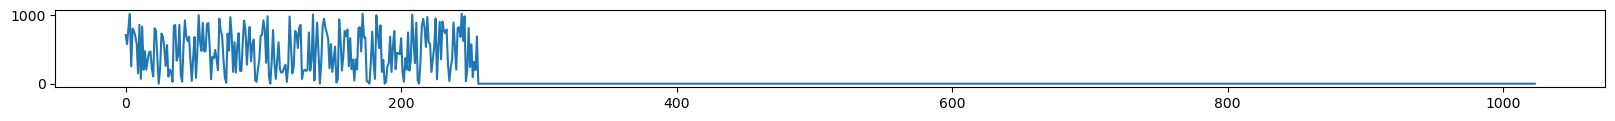

Finished epoch number 1 with a total of 13824 debug_seqs
 time: 2025-08-21 21:03:58.725687, epoch 2,  Loss: 6.6962
Starting inference... with numtokens=1024
Generating 768 audio samples... using numtokens=1024
Inference complete.


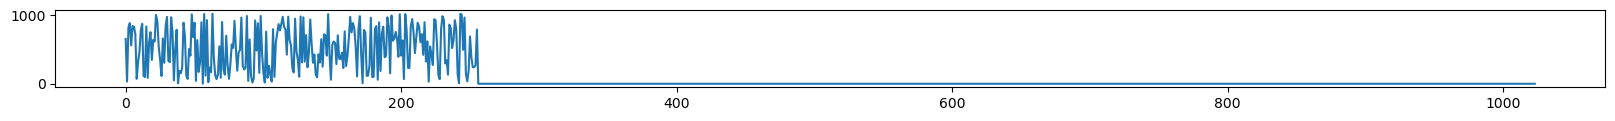

In [ ]:
# Train!
#*************************************
list_of_losses = []

print('{:%Y-%m-%d %H:%M:%S} Starting training...'.format(datetime.now()))
start_time = time.monotonic()
#-------------------------------------------------------------------------------
for epoch in range(start_epoch, start_epoch+params['num_epochs']):
    train(rnn,epoch)
#-------------------------------------------------------------------------------
writer.close()
elapsed_time = time.monotonic() - start_time
print('Training time taken:',time_taken(elapsed_time))

#Just make sure the final model gets saved
checkpoint_data = {
    'epoch': epoch+1,
    'model_state_dict': rnn.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}
# Save numbered checkpoint
numbered_path = os.path.join(f"{out_dir}/checkpoints", f"checkpoint_{epoch+1}.pt")
torch.save(checkpoint_data, numbered_path)
print(f"Saved checkpoint at epoch {epoch+1}")
# Copy to "last" (much faster than saving twice)
last_path = os.path.join(f"{out_dir}/checkpoints", "last_checkpoint.pt")
shutil.copy2(numbered_path, last_path)


In [ ]:
# Plot the loss over time
#*************************************
plt.figure()
plt.plot(list_of_losses)
plt.show()  # This will actually display the plot

In [ ]:
list_of_losses